<a href="https://colab.research.google.com/github/vocaltrainer/baseline_woo/blob/main/%EC%98%A4%EB%94%94%EC%98%A4_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류
2. 오디오 데이터에 특화된 분류



### 데이터 준비 및 전처리

In [ ]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

<ipython-input-3-99cc85cc827f>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정

In [ ]:
midi_file='/content/drive/MyDrive/잡다/GeneralMidi.wav'

* wmv 파일에는 128개 악기와 46개 타악기의 음을 50개씩 2초 간격으로 존재
* 그중 10개만 사용

In [ ]:
instruments = [0,10,20,30,40,50,60,70,80,90]
num_notes = 50
sec = 2

audio=[]
inst=[]
#itertools.product : 데카르트곱을 함으로써 모든 경우의 수
for inst_idx, note in itertools.product(range(len(instruments)),range(num_notes)):
  instrument = instruments[inst_idx]
  offset = (instrument*num_notes*sec) + (note*sec)
  print('instrument: {}, note: {}, offset: {}'.format(instrument,note,offset))
  y,sr=librosa.load(midi_file,sr=None,offset=offset,duration=2.0)
  audio.append(y)
  inst.append(inst_idx)

instrument: 0, note: 0, offset: 0
instrument: 0, note: 1, offset: 2
instrument: 0, note: 2, offset: 4
instrument: 0, note: 3, offset: 6
instrument: 0, note: 4, offset: 8
instrument: 0, note: 5, offset: 10
instrument: 0, note: 6, offset: 12
instrument: 0, note: 7, offset: 14
instrument: 0, note: 8, offset: 16
instrument: 0, note: 9, offset: 18
instrument: 0, note: 10, offset: 20
instrument: 0, note: 11, offset: 22
instrument: 0, note: 12, offset: 24
instrument: 0, note: 13, offset: 26
instrument: 0, note: 14, offset: 28
instrument: 0, note: 15, offset: 30
instrument: 0, note: 16, offset: 32
instrument: 0, note: 17, offset: 34
instrument: 0, note: 18, offset: 36
instrument: 0, note: 19, offset: 38
instrument: 0, note: 20, offset: 40
instrument: 0, note: 21, offset: 42
instrument: 0, note: 22, offset: 44
instrument: 0, note: 23, offset: 46
instrument: 0, note: 24, offset: 48
instrument: 0, note: 25, offset: 50
instrument: 0, note: 26, offset: 52
instrument: 0, note: 27, offset: 54
instrum

In [ ]:
import numpy as np

audio_np = np.array(audio,np.float32)  # (10개의 악기의 각 50음, y값)
inst_np = np.array(inst,np.int16)      # 10개의 악기

print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


10개 악기의 파형 시각화

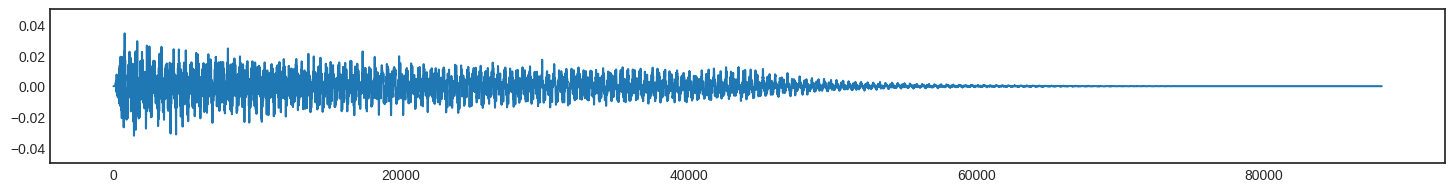

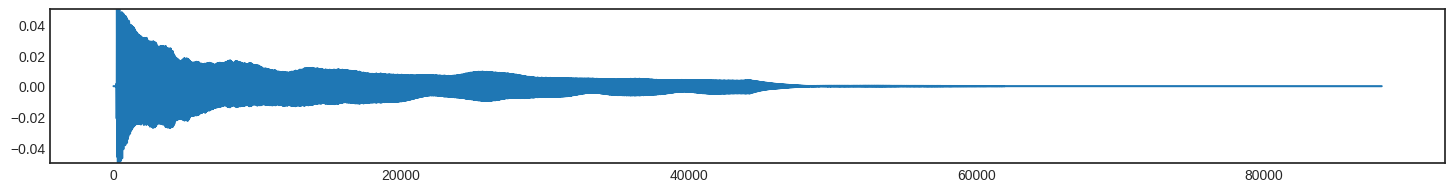

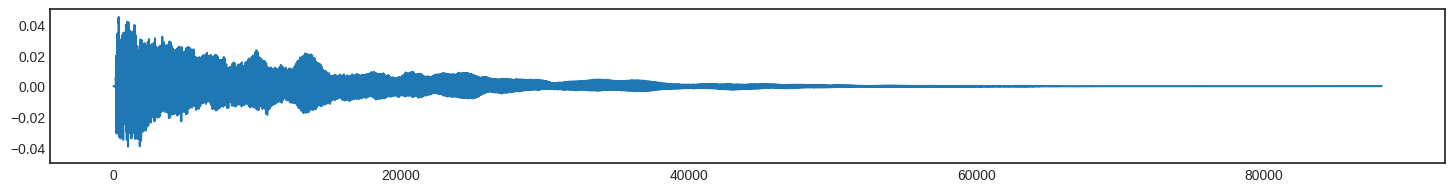

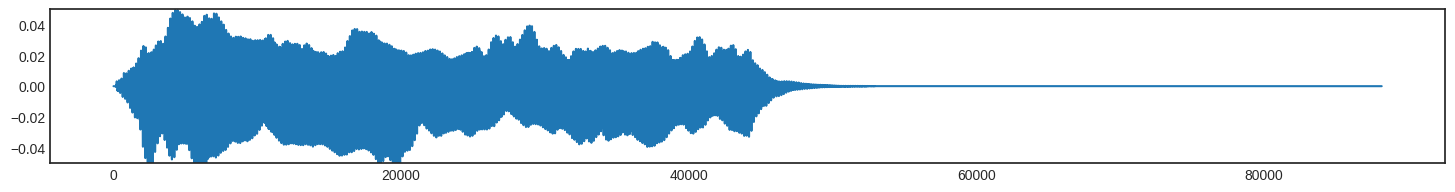

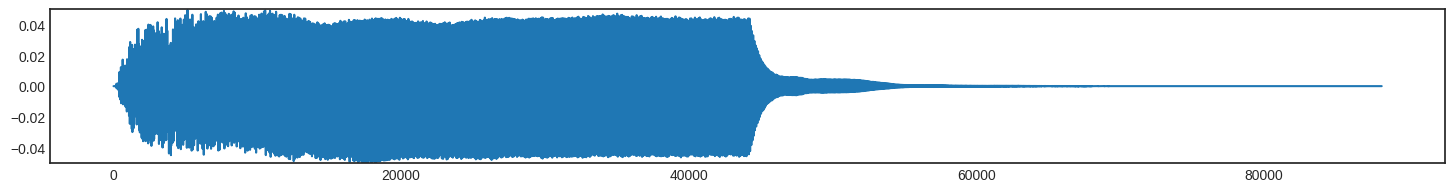

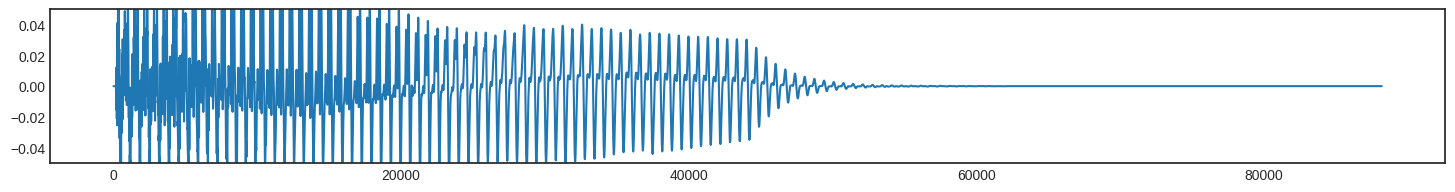

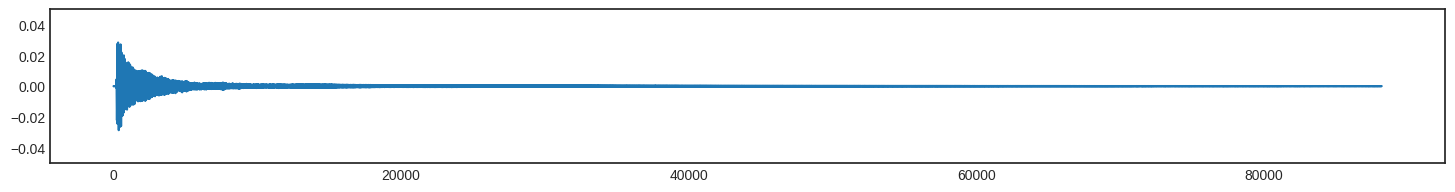

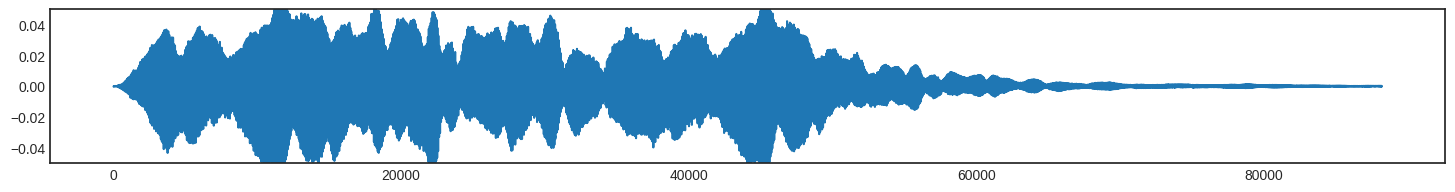

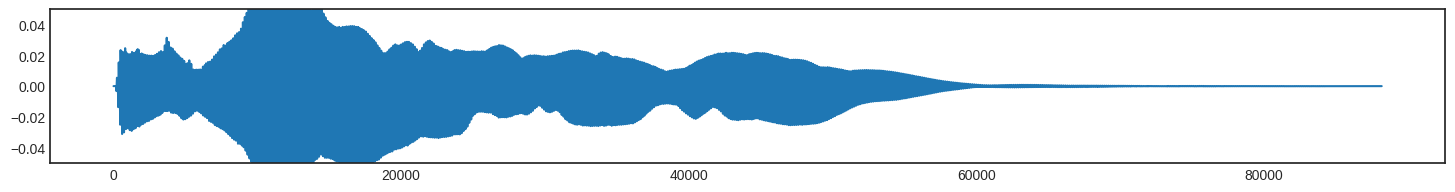

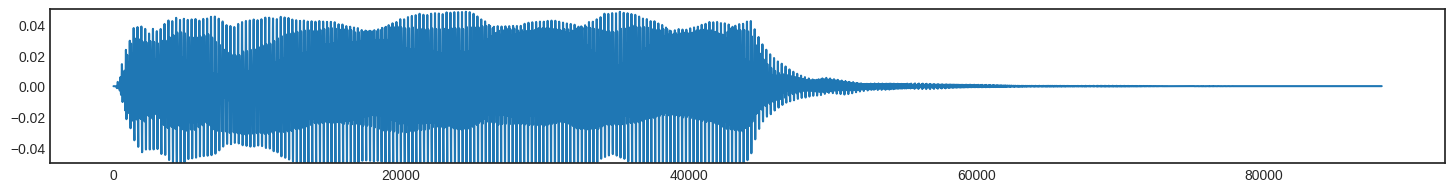

In [ ]:
for idx in range(0,len(audio_np),num_notes):  #range(0,500,50)
  plt.figure(figsize=(18,2))
  plt.plot(audio_np[idx])
  plt.ylim(-0.05,0.05)

In [ ]:
#0은 피아노
print(inst_np[0])
ipd.Audio(audio_np[0], rate=sr)

0


In [ ]:
print(inst_np[50])
ipd.Audio(audio_np[50], rate=sr)

1


In [ ]:
print(inst_np[100])
ipd.Audio(audio_np[100], rate=sr)

2


In [ ]:
print(inst_np[150])
ipd.Audio(audio_np[150], rate=sr)

3


In [ ]:
print(inst_np[200])
ipd.Audio(audio_np[200], rate=sr)

4


전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

## 1-1.Constant-Q로 머신러닝 분류

### 데이터 준비

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음 (음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음
* 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
* Constant-Q 변환은 주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되기 때문에(저주파는 저해상도, 고주파는 고해상도) **음악을 처리하는 데에 푸리에 변환보다 유리**

*   주파수 대역을 저장할 리스트 `audio_cqt` 선언
*   constant-Q 변환할 때는 변환할 오디오 데이터와 sampling rate가 필요
*   해당 데이터에서는 sampling rate가 모두 동일하므로 따로 처리가 필요하지 않음




*   변환에는 앞서 준비한 데이터를 가져와 사용하며, Constant-Q 변환에는 `librosa.cqt` 함수를 사용
*   여기서 `n_bins`는 옥타브 단계 및 개수를, `bins_per_octave`는 한 옥타브가 가지는 단계를 의미
*   라벨에 대해선 원 핫 인코딩을 적용



In [ ]:
audio_cqt=[]
for y in audio:
  ret = librosa.cqt(y=y,sr=sr,hop_length=1024, n_bins=24*7, bins_per_octave=24)
  ret = np.abs(ret)
  audio_cqt.append(ret)

ret.shape

(168, 87)

* 앞서 생성한 주파수 대역을 spectrogram으로 시각화
* 악기 간 spectrogram을 비교해보면 차이가 존재함을 알 수 있음

<ipython-input-20-fade6357645a>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(amp_db,sr=sr,x_axis='time',y_axis='cqt_note')


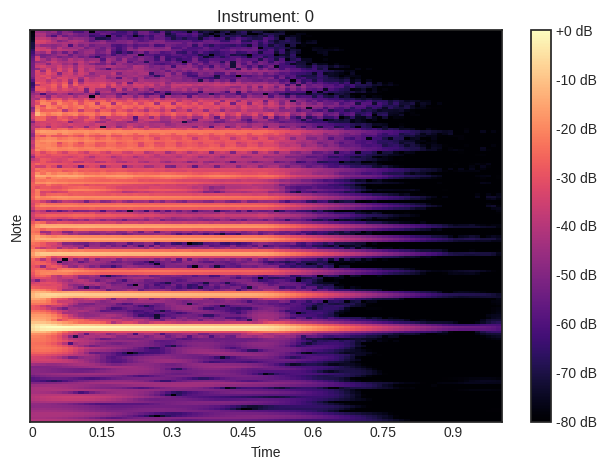

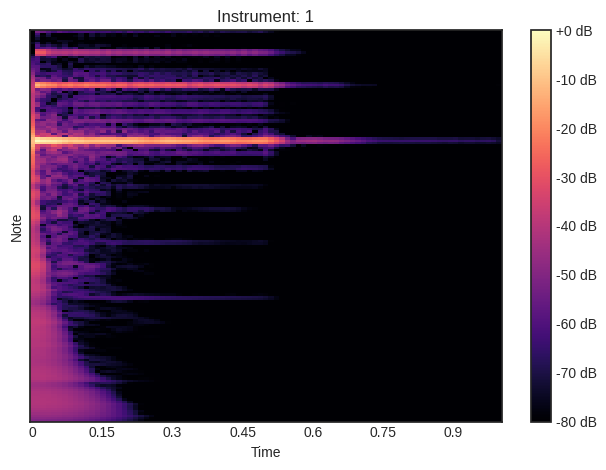

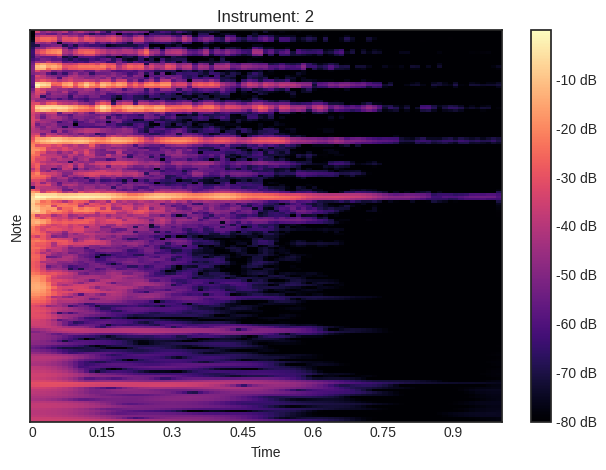

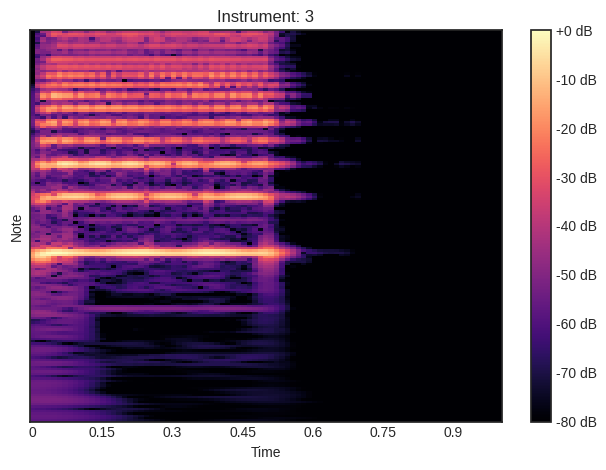

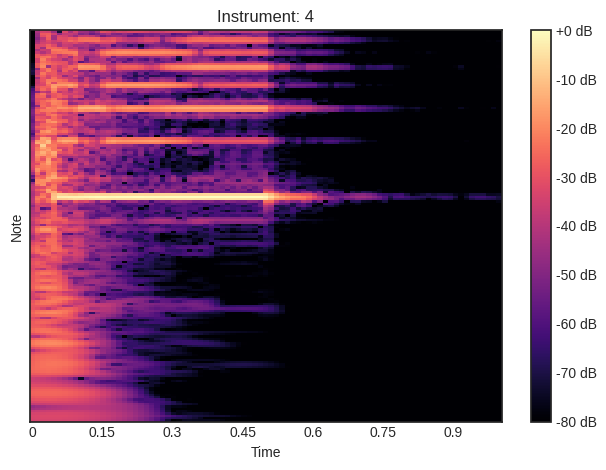

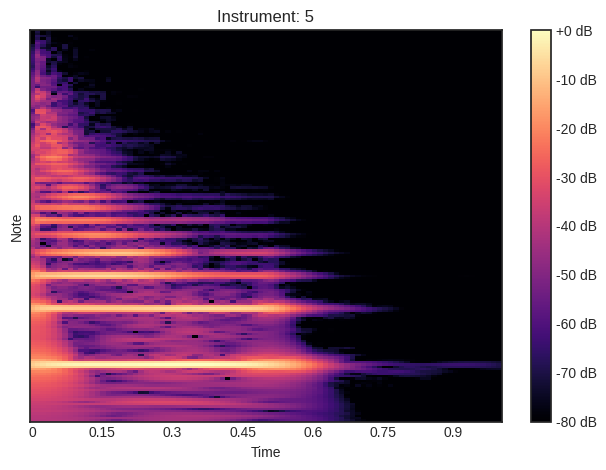

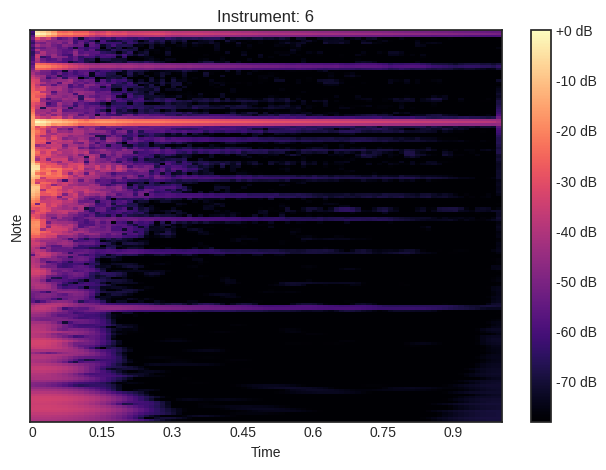

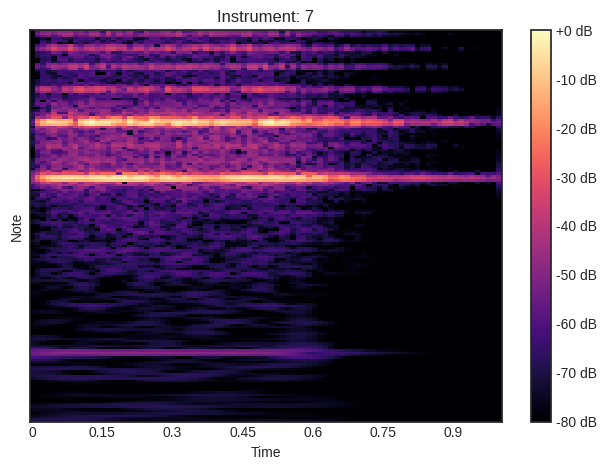

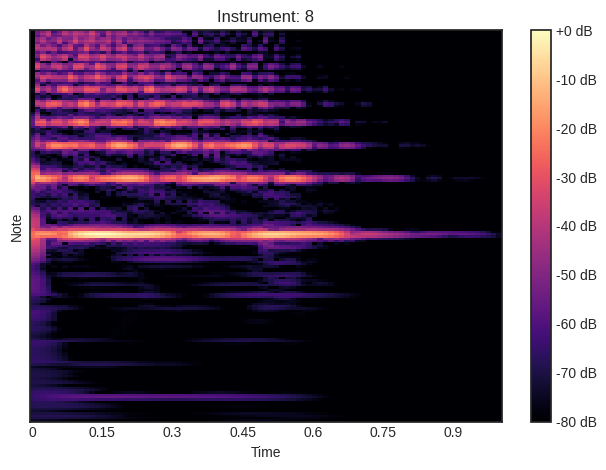

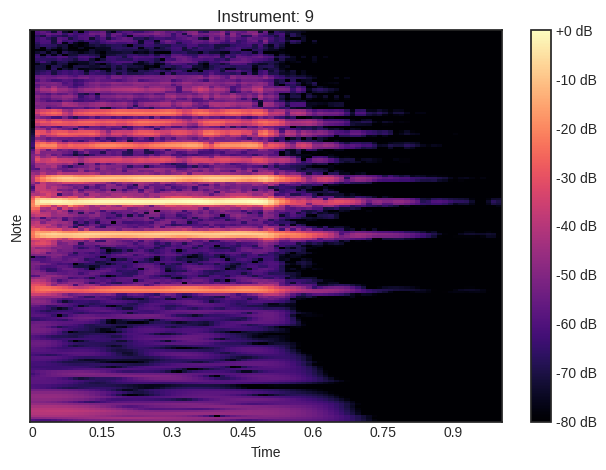

In [ ]:
for i in range(0,len(instruments)*num_notes,num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]),ref=np.max)
  librosa.display.specshow(amp_db,sr=sr,x_axis='time',y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

* 훈련 데이터와 실험 데이터를 분리

In [ ]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst,np.int16)
print(cqt_np.shape, inst_np.shape)

(500, 168, 87) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [ ]:
cqt_np = cqt_np.reshape(500,168*87)



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [ ]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(cqt_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616)
(100, 14616)
(400,)
(100,)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x,train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.3


### Support Vector Machine

In [ ]:
from sklearn import svm

SVM = svm.SVC(kernel ='linear')
SVM.fit(train_x,train_y)
pred=SVM.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.36


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x,train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.63


## 1-2.Constant-Q로 딥러닝 분류

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

cqt_np = np.array(audio_cqt, np.float32)
cqt_array = np.expand_dims(cqt_np,-1)
inst_cat = to_categorical(inst_np)


train_x, test_x, train_y, test_y = train_test_split(cqt_array,inst_cat, test_size=0.2)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 168, 87, 1)
(100, 168, 87, 1)
(400, 10)
(100, 10)


In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model = Sequential()
  input = Input(shape=(168,87,1))
  output = Conv2D(128,3,strides=1,padding='same',activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(output)

  output = Conv2D(256,3,strides=1,padding='same',activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(output)

  output = Conv2D(512,3,strides=1,padding='same',activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
# model = model_build()
# model.summary()
#램문제로 돌리지 못함

## 2-1.spectrogram으로 머신러닝 분류

In [ ]:
audio_stft = []
for y in audio:
  #n_fft:frame 하나당 sample수, hop_length: 전체 frame 수
  ret = librosa.stft(y=y, n_fft= 2048, hop_length=512)
  magnitude = np.abs(ret)
  log_spectrogram = librosa.amplitude_to_db(magnitude)
  audio_stft.append(log_spectrogram)

log_spectrogram.shape
# 1025 : 1+ n_fft//2
# 173 : 1+ len(y)//hop_length

(1025, 173)

<ipython-input-45-0fd6d5423199>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(audio_stft[i],sr=sr,x_axis='time',y_axis='cqt_note')


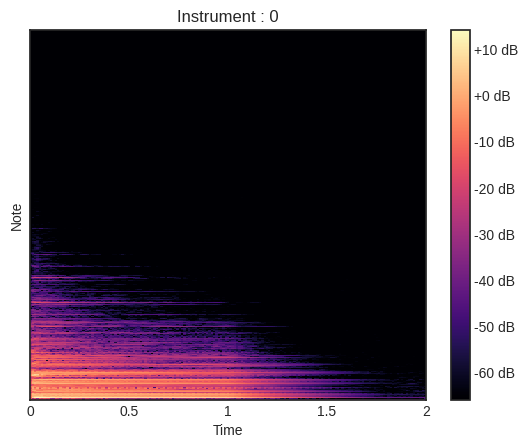

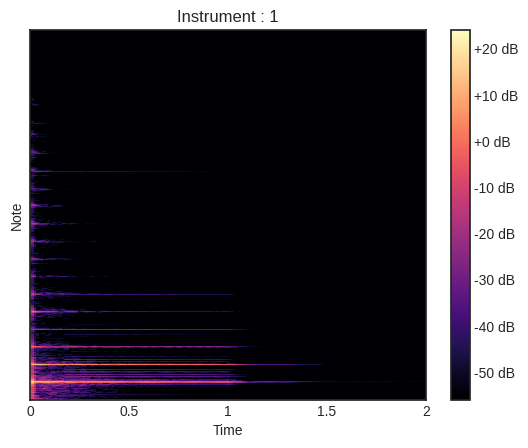

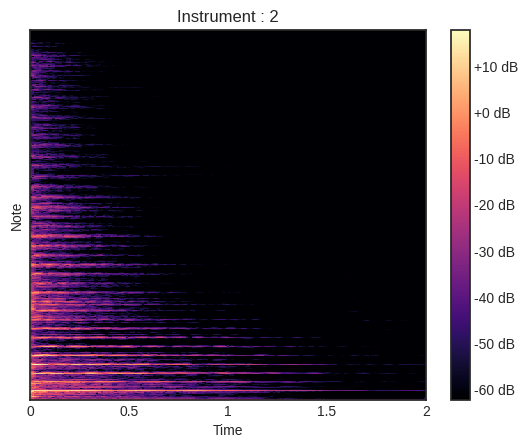

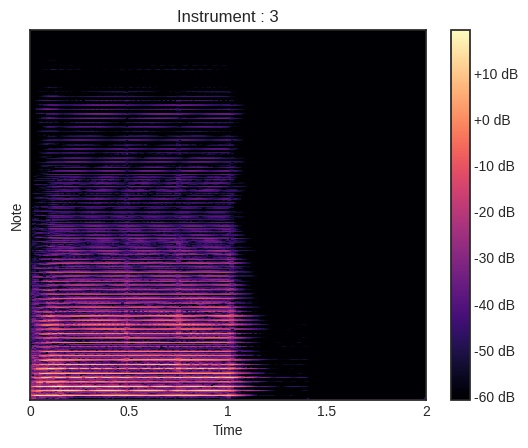

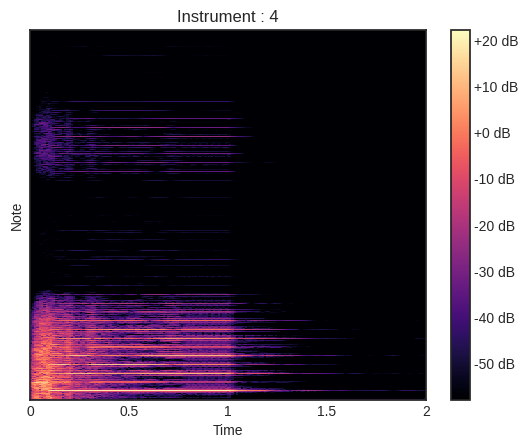

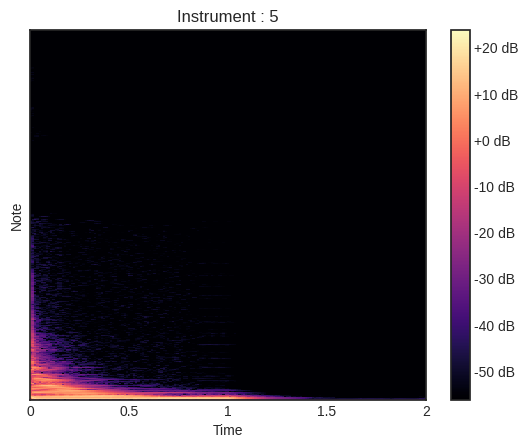

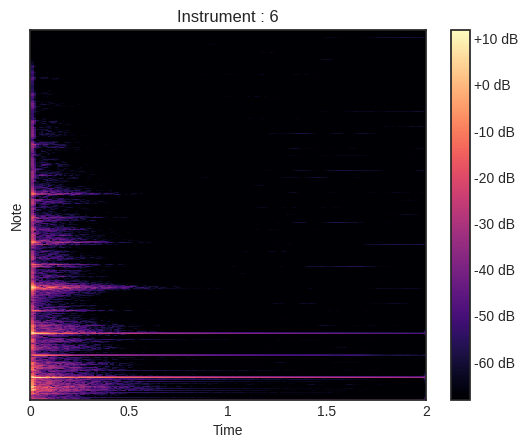

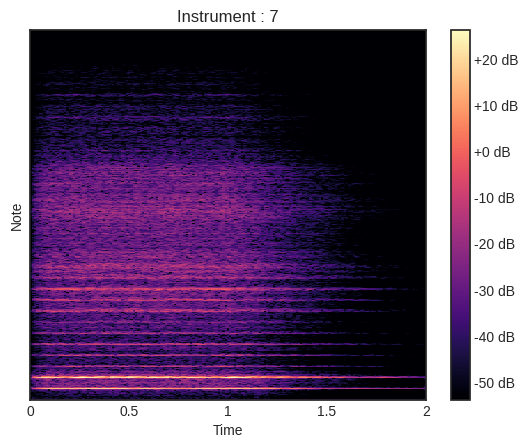

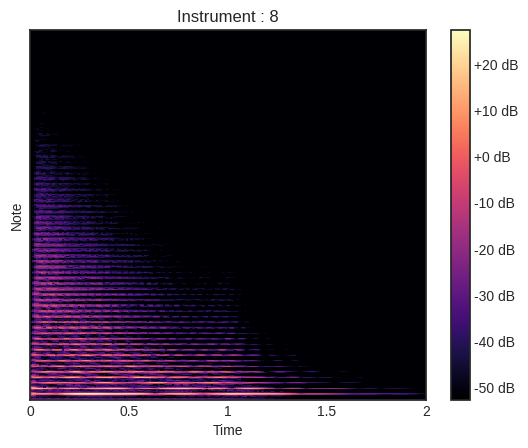

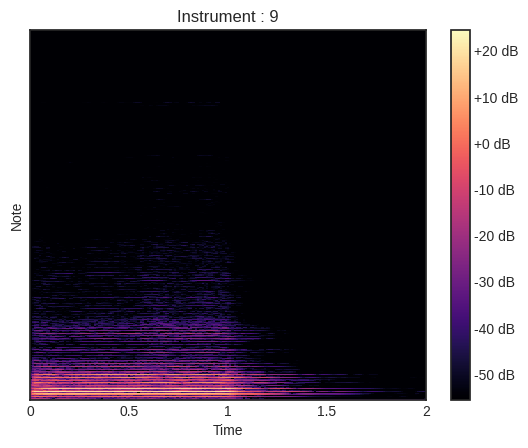

In [ ]:
for i in range(0,len(instruments)*num_notes, num_notes):

  librosa.display.specshow(audio_stft[i],sr=sr,x_axis='time',y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument : {}'.format(inst[i]))
  plt.show()

In [ ]:
stft_np = np.array(audio_stft,np.float32)
inst_np = np.array(inst,np.int16)

print(stft_np.shape, inst_np.shape)

(500, 1025, 173) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [ ]:
stft_np = stft_np.reshape((500,1025*173))



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(stft_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(stft_np,inst_np, test_size=0.2)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 177325)
(100, 177325)
(400,)
(100,)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x,train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.91


### Support Vector Machine

In [ ]:
from sklearn import svm

SVM = svm.SVC(kernel ='linear')
SVM.fit(train_x,train_y)
pred=SVM.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.95


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x,train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.75


## 3-1.MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [ ]:
audio_mfcc=[]
for y in audio:
  ret = librosa.feature.mfcc(y=y, sr=sr,hop_length=512, n_mfcc=21) #n_mfcc:추출할 특징 수
  audio_mfcc.append(ret)

In [ ]:
ret.shape

(21, 173)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9839 (\N{MUSIC SHARP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


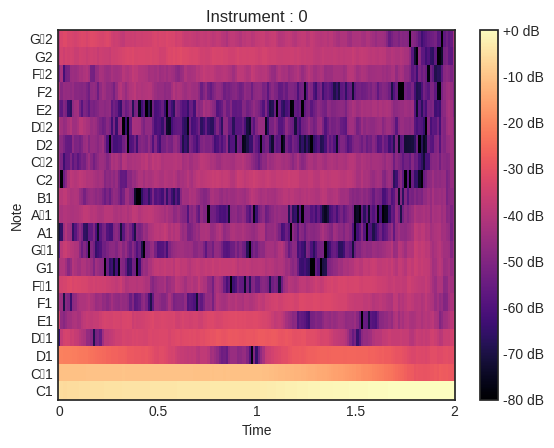

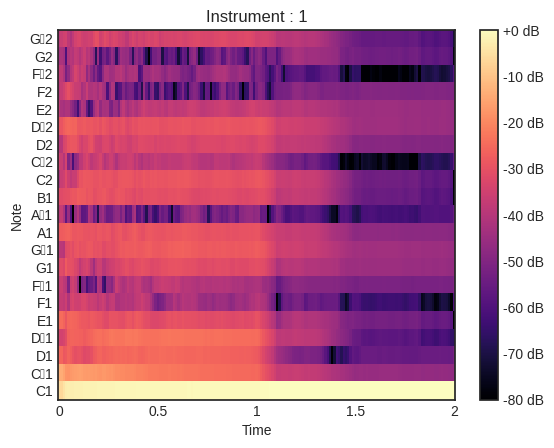

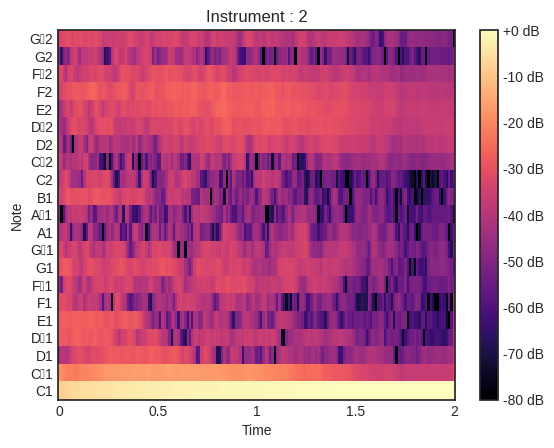

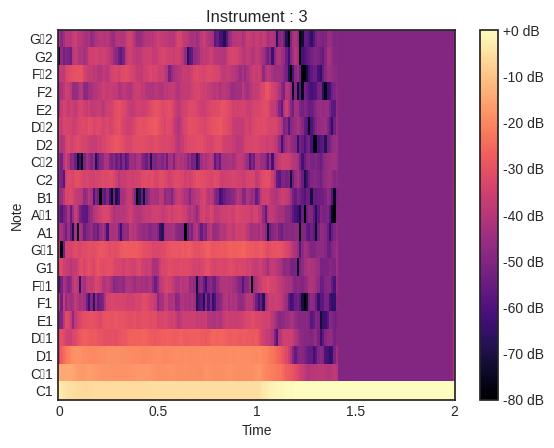

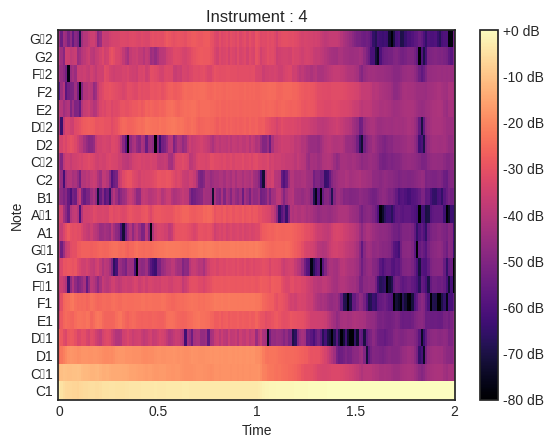

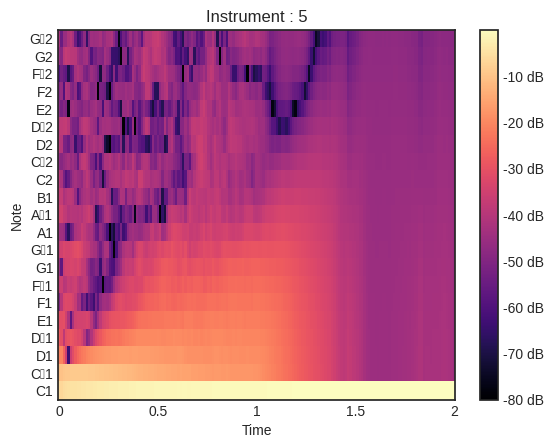

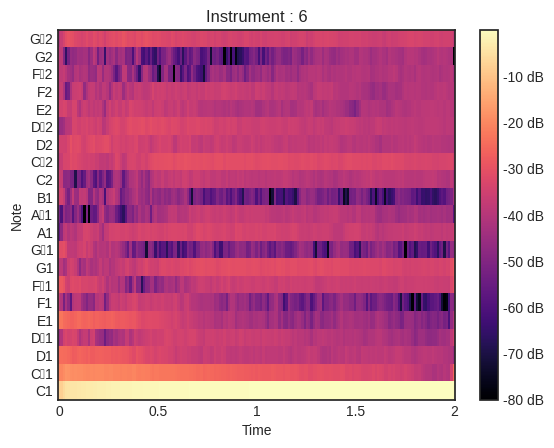

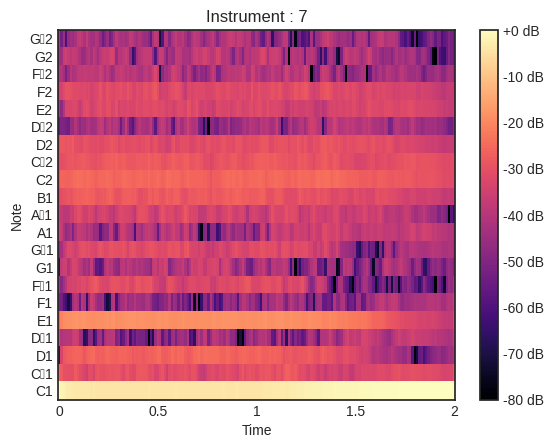

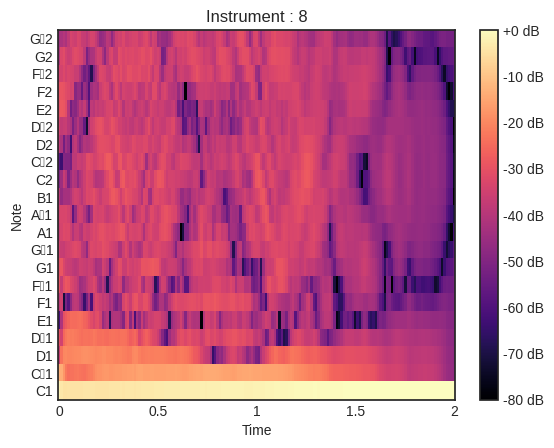

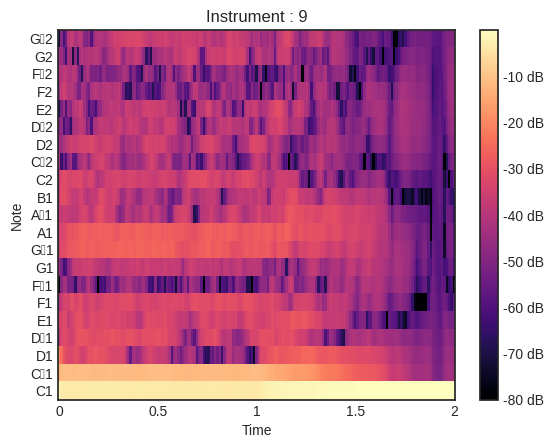

In [ ]:
for i in range(0,len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]),ref=np.max)
  librosa.display.specshow(amp_db,sr=sr,x_axis='time',y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument : {}'.format(inst[i]))
  plt.show()


In [ ]:
mfcc_np = np.array(audio_mfcc,np.float32)
inst_np = np.array(inst,np.int16)

print(mfcc_np.shape, inst_np.shape)

(500, 21, 173) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [ ]:
mfcc_np = mfcc_np.reshape((500,21*173))



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(mfcc_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(mfcc_np,inst_np, test_size=0.2)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 3633)
(100, 3633)
(400,)
(100,)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x,train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.95


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Support Vector Machine

In [ ]:
from sklearn import svm

SVM = svm.SVC(kernel ='linear')
SVM.fit(train_x,train_y)
pred=SVM.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.98


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x,train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.84


## 3-2. MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [ ]:
from keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_np = mfcc_np.reshape((500,21*173))

mfcc_array = np.expand_dims(mfcc_np,-1)

inst_cat = to_categorical(inst_np)


train_x, test_x, train_y, test_y = train_test_split(mfcc_array,inst_cat, test_size=0.2)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 3633, 1)
(100, 3633, 1)
(400, 10)
(100, 10)


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()
  input = Input(shape=(3633,), name='input')
  output = Dense(512, activation='relu',name='hidden1')(input)
  output = Dense(256, activation='relu',name='hidden2')(output)
  output = Dense(128, activation='relu',name='hidden3')(output)
  output = Dense(10, activation='softmax',name='output')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
model = model_build()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3633)]            0         
                                                                 
 hidden1 (Dense)             (None, 512)               1860608   
                                                                 
 hidden2 (Dense)             (None, 256)               131328    
                                                                 
 hidden3 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 2026122 (7.73 MB)
Trainable params: 2026122 (7.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(train_x,train_y,epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 2s 241ms/step - loss: 219.6318 - accuracy: 0.0906 - val_loss: 205.9374 - val_accuracy: 0.3000
Epoch 2/30
3/3 [==============================] - 0s 104ms/step - loss: 231.9968 - accuracy: 0.1969 - val_loss: 214.1278 - val_accuracy: 0.2000
Epoch 3/30
3/3 [==============================] - 0s 98ms/step - loss: 229.0250 - accuracy: 0.1688 - val_loss: 128.5415 - val_accuracy: 0.2125
Epoch 4/30
3/3 [==============================] - 0s 88ms/step - loss: 94.6337 - accuracy: 0.2188 - val_loss: 46.4205 - val_accuracy: 0.2500
Epoch 5/30
3/3 [==============================] - 0s 92ms/step - loss: 48.1925 - accuracy: 0.2594 - val_loss: 56.8521 - val_accuracy: 0.2750
Epoch 6/30
3/3 [==============================] - 0s 64ms/step - loss: 46.9315 - accuracy: 0.3250 - val_loss: 37.1310 - val_accuracy: 0.3750
Epoch 7/30
3/3 [==============================] - 0s 59ms/step - loss: 23.3132 - accuracy: 0.4719 - val_loss: 21.9305 - val_accuracy: 0.3500
Epoch

In [ ]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1,len(loss)+1)
  fig = plt.figure(figsize=(14,5))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(epochs,loss,'b--',label='train_loss')
  ax1.plot(epochs,val_loss,'r:',label='valid_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(epochs,acc,'b--',label='train_acc')
  ax2.plot(epochs,val_acc,'r:',label='valid_acc')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()

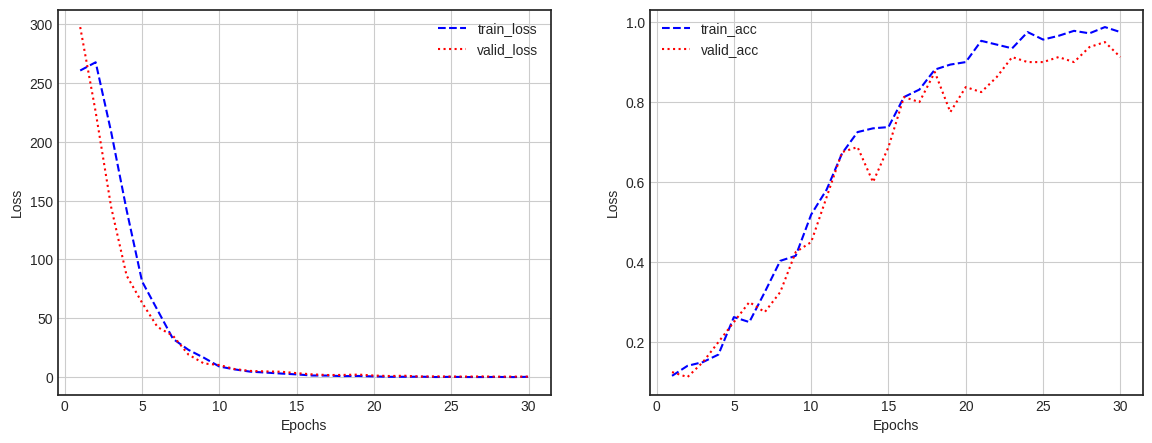

In [ ]:
plot_history(history.history)

In [ ]:
model.evaluate(test_x,test_y)

4/4 [==============================] - 0s 7ms/step - loss: 1.8044 - accuracy: 0.8800


[1.804436445236206, 0.8799999952316284]

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array = np.expand_dims(mfcc_np,-1)
inst_cat = to_categorical(inst_np)


train_x, test_x, train_y, test_y = train_test_split(mfcc_array,inst_cat, test_size=0.2)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 21, 173, 1)
(100, 21, 173, 1)
(400, 10)
(100, 10)


In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model = Sequential()
  input = Input(shape=(21,173,1))
  output = Conv2D(128,3,strides=1,padding='same',activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(output)

  output = Conv2D(256,3,strides=1,padding='same',activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(output)

  output = Conv2D(512,3,strides=1,padding='same',activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
model = model_build()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 173, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 173, 512)      5120      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 87, 512)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 489984)            0         
                                                                 
 dense (Dense)               (None, 512)               250872320 
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                           

In [ ]:
history = model.fit(train_x,train_y,epochs=20, batch_size=128,validation_split=0.2)

Epoch 1/20
3/3 [==============================] - 42s 12s/step - loss: 703.6029 - accuracy: 0.1000 - val_loss: 1416.7278 - val_accuracy: 0.1250
Epoch 2/20
3/3 [==============================] - 40s 11s/step - loss: 1677.5621 - accuracy: 0.1219 - val_loss: 1346.8522 - val_accuracy: 0.1000
Epoch 3/20
3/3 [==============================] - 38s 12s/step - loss: 992.6167 - accuracy: 0.1219 - val_loss: 690.2953 - val_accuracy: 0.1000
Epoch 4/20
3/3 [==============================] - 56s 16s/step - loss: 642.3143 - accuracy: 0.0969 - val_loss: 404.1069 - val_accuracy: 0.1375
Epoch 5/20
3/3 [==============================] - 45s 14s/step - loss: 347.3040 - accuracy: 0.1250 - val_loss: 188.0283 - val_accuracy: 0.1625
Epoch 6/20
3/3 [==============================] - 40s 13s/step - loss: 141.2331 - accuracy: 0.2562 - val_loss: 124.3321 - val_accuracy: 0.2000
Epoch 7/20
3/3 [==============================] - 41s 13s/step - loss: 103.9039 - accuracy: 0.2438 - val_loss: 34.9313 - val_accuracy: 0.27

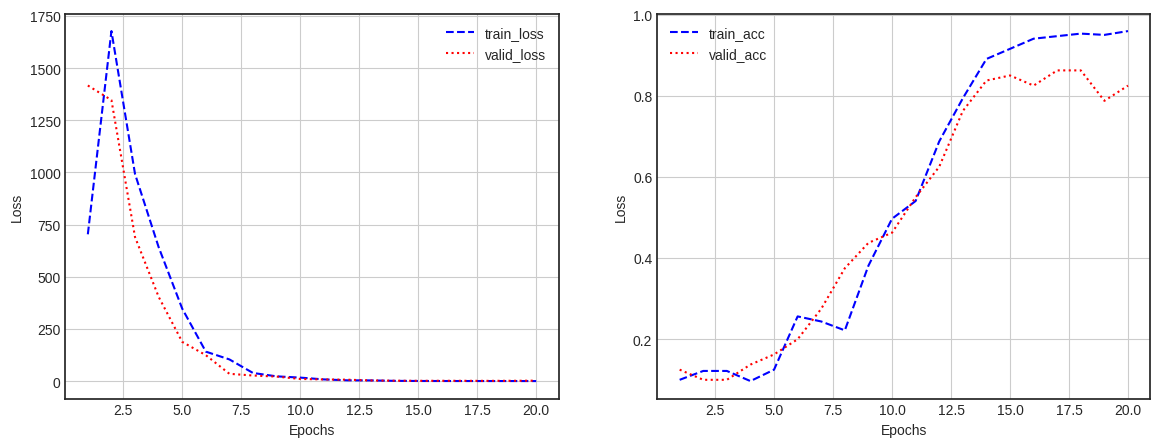

In [ ]:
plot_history(history.history)



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [ ]:
model.evaluate(test_x,test_y)

4/4 [==============================] - 2s 510ms/step - loss: 1.6659 - accuracy: 0.8200


[1.6659141778945923, 0.8199999928474426]